<a href="https://colab.research.google.com/github/realnihal/Food-Vision-Using-Tensorflow/blob/main/Food_Vision_Using_EfficientNetB0_Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Since we are planning to use mixed learning, we need a compatible GPU.
This model is being trained on Google's colab and they provides 3 types of free Nvidia GPU's.

1. K80(not compatible)
2. P100(not compatible)
3. Tesla T4(compatible)

Knowing this we need access to an Nvidia Tesla T4(from colab) or any GPU with a compute score of 7+ of our own.

Lets find out our GPU type by the following command.

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-382f14ed-612e-128d-516f-77d48c656a16)


In [2]:
import tensorflow as tf
print(tf.__version__)

2.4.1


In [ ]:
# Downgrade Tensorflow Version (run this in Google Colab) 
!pip install tensorflow==2.4.1

In [4]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

--2021-08-04 19:46:39--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-08-04 19:46:40 (97.0 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [5]:
import tensorflow_datasets as tfds

In [6]:
datasets_list = tfds.list_builders()
print("food101" in datasets_list)

True


In [7]:
#Loading the dataset
(train_data, test_data), ds_info = tfds.load(name='food101',
                                             split=['train','validation'],
                                             shuffle_files=True,
                                             as_supervised=True,
                                             with_info=True)

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incomplete38C81Y/food101-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incomplete38C81Y/food101-validation.tfrecord


Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [8]:
#Features of Food101 from TFDS
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [9]:
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [10]:
train_one_sample = train_data.take(1)
train_one_sample

<TakeDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

In [11]:
for image, label in train_one_sample:
  print(f'''
  Image shape: {image.shape}
  Iimage datatype: {image.dtype}
  Target class from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
  ''')


  Image shape: (512, 512, 3)
  Iimage datatype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 24
  Class name (str form): clam_chowder
  


In [12]:
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[41, 32, 27],
        [43, 34, 29],
        [43, 34, 29],
        ...,
        [53, 50, 41],
        [48, 48, 38],
        [45, 45, 35]],

       [[40, 31, 26],
        [43, 34, 29],
        [45, 36, 31],
        ...,
        [46, 43, 34],
        [46, 46, 36],
        [49, 49, 39]],

       [[40, 31, 26],
        [44, 35, 30],
        [46, 37, 32],
        ...,
        [48, 45, 36],
        [48, 48, 40],
        [52, 52, 44]],

       ...,

       [[90, 78, 66],
        [93, 81, 69],
        [95, 83, 71],
        ...,
        [20,  8,  8],
        [20,  8,  8],
        [21,  9,  9]],

       [[93, 81, 69],
        [95, 83, 71],
        [96, 84, 72],
        ...,
        [21,  9,  9],
        [22, 10, 10],
        [23, 11, 11]],

       [[98, 86, 74],
        [99, 87, 75],
        [97, 85, 73],
        ...,
        [24, 12, 12],
        [26, 14, 14],
        [27, 15, 15]]], dtype=uint8)>

In [13]:
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=1>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

(-0.5, 511.5, 511.5, -0.5)

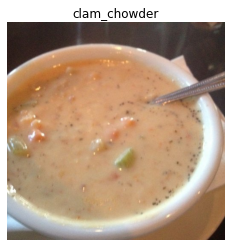

In [14]:
#Plotting an image from the dataset to check if our labels are correct
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False)

In [15]:

# Make a function for preprocessing images
def preprocess_img(image, label, img_shape=224):
  """
  Converts image datatype from 'uint8' -> 'float32' and reshapes image to
  [img_shape, img_shape, color_channels]
  """
  image = tf.image.resize(image, [img_shape, img_shape]) # reshape to img_shape
  #image = image/255.0 (not required)
  return tf.cast(image, tf.float32), label # return (float32_image, label) tuple

In [16]:
preprocessed_img = preprocess_img(image, label)[0]
print(f"Image before preprocessing:\n {image[:2]}...,\nShape: {image.shape},\nDatatype: {image.dtype}\n")
print(f"Image after preprocessing:\n {preprocessed_img[:2]}...,\nShape: {preprocessed_img.shape},\nDatatype: {preprocessed_img.dtype}")

Image before preprocessing:
 [[[41 32 27]
  [43 34 29]
  [43 34 29]
  ...
  [53 50 41]
  [48 48 38]
  [45 45 35]]

 [[40 31 26]
  [43 34 29]
  [45 36 31]
  ...
  [46 43 34]
  [46 46 36]
  [49 49 39]]]...,
Shape: (512, 512, 3),
Datatype: <dtype: 'uint8'>

Image after preprocessing:
 [[[42.05612  33.05612  28.056124]
  [42.09694  33.09694  28.09694 ]
  [43.64796  34.21939  29.433674]
  ...
  [64.80089  55.586624 46.586624]
  [50.622417 46.69386  37.69386 ]
  [47.02044  47.02044  37.02044 ]]

 [[44.760204 35.760204 30.760204]
  [46.066326 37.066326 32.066326]
  [49.357147 39.928574 35.14286 ]
  ...
  [64.33646  56.78038  48.62224 ]
  [53.836746 49.908188 40.908188]
  [52.015156 50.224434 42.821342]]]...,
Shape: (224, 224, 3),
Datatype: <dtype: 'float32'>


In [17]:
# Map preprocessing function to training data (and paralellize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map prepreprocessing function to test data
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Turn test data into batches (don't need to shuffle)
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)

In [18]:
train_data, test_data

(<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>,
 <PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>)

In [19]:

# Create TensorBoard callback (already have "create_tensorboard_callback()" from a previous notebook)
from helper_functions import create_tensorboard_callback

# Create ModelCheckpoint callback to save model's progress
checkpoint_path = "model_checkpoints/cp.ckpt" # saving weights requires ".ckpt" extension
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor = 'val_accuracy', # save the model weights with best validation accuracy
                                                      save_best_only=True, # only save the best weights
                                                      save_weights_only=True, # only save model weights (not whole model)
                                                      verbose=1)

In [20]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


In [21]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False # freeze base model layers

# Create Functional model 
inputs = layers.Input(shape=input_shape, name="input_layer")
# Note: EfficientNetBX models have rescaling built-in but if your model didn't you could have a layer like below
# x = preprocessing.Rescaling(1./255)(x)
x = base_model(inputs, training=False) # set base_model to inference mode only
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dense(len(class_names))(x) # want one output neuron per class 
# Separate activation of output layer so we can output float32 activations
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x) 
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss="sparse_categorical_crossentropy", # Use sparse_categorical_crossentropy when labels are *not* one-hot
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

16711680/16705208 [==============================] - 0s 0us/step


In [22]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
pooling_layer (GlobalAverage (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 101)               129381    
_________________________________________________________________
softmax_float32 (Activation) (None, 101)               0         
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


In [23]:
for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


In [24]:
for layer in model.layers[1].layers[:20]: # only check the first 20 layers to save output space
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 False float32 <Policy "float32">
rescaling False float32 <Policy "mixed_float16">
normalization False float32 <Policy "float32">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block2a_expand_conv False float32 <Policy "mixed_float16">
block2a_expand_bn False float32 <

In [25]:
history_101_food_classes_feature_extract = model.fit(train_data, 
                                                     epochs=3,
                                                     steps_per_epoch=len(train_data),
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     callbacks=[create_tensorboard_callback("training_logs", 
                                                                                            "efficientnetb0_101_classes_all_data_feature_extract"),
                                                                model_checkpoint])

Saving TensorBoard log files to: training_logs/efficientnetb0_101_classes_all_data_feature_extract/20210804-195914
Epoch 1/3
2368/2368 [==============================] - 233s 83ms/step - loss: 2.3168 - accuracy: 0.4668 - val_loss: 1.2177 - val_accuracy: 0.6780

Epoch 00001: val_accuracy improved from -inf to 0.67797, saving model to model_checkpoints/cp.ckpt
Epoch 2/3
2368/2368 [==============================] - 176s 74ms/step - loss: 1.3108 - accuracy: 0.6622 - val_loss: 1.1202 - val_accuracy: 0.6989

Epoch 00002: val_accuracy improved from 0.67797 to 0.69889, saving model to model_checkpoints/cp.ckpt
Epoch 3/3
2368/2368 [==============================] - 175s 73ms/step - loss: 1.1437 - accuracy: 0.7031 - val_loss: 1.0980 - val_accuracy: 0.7058

Epoch 00003: val_accuracy improved from 0.69889 to 0.70577, saving model to model_checkpoints/cp.ckpt


In [26]:
results_feature_extract_model = model.evaluate(test_data)
results_feature_extract_model

790/790 [==============================] - 57s 72ms/step - loss: 1.0875 - accuracy: 0.7069


[1.087457299232483, 0.7069306969642639]

In [27]:
model.save("101_food_feature_extract_mixedpred_model")

INFO:tensorflow:Assets written to: 101_food_feature_extract_mixedpred_model/assets


INFO:tensorflow:Assets written to: 101_food_feature_extract_mixedpred_model/assets


In [ ]:
loaded_model = tf.keras.models.load_model("101_food_feature_extract_mixedpred_model")
loaded_model.load_weights(checkpoint_path)

In [29]:
for layer in loaded_model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 True float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


In [30]:
test_eval = loaded_model.evaluate(test_data)

790/790 [==============================] - 49s 60ms/step - loss: 1.0875 - accuracy: 0.7069


In [31]:
results_feature_extract_model == test_eval

[1.087457299232483, 0.7069306969642639]

In [33]:
for layer in loaded_model.layers:
  layer.trainable = True # set all layers to trainable
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy) # make sure loaded model is using mixed precision dtype_policy ("mixed_float16")

input_layer True float32 <Policy "float32">
efficientnetb0 True float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


In [36]:
for layer in loaded_model.layers[1].layers[:20]:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 True float32 <Policy "float32">
rescaling True float32 <Policy "mixed_float16">
normalization True float32 <Policy "float32">
stem_conv_pad True float32 <Policy "mixed_float16">
stem_conv True float32 <Policy "mixed_float16">
stem_bn True float32 <Policy "mixed_float16">
stem_activation True float32 <Policy "mixed_float16">
block1a_dwconv True float32 <Policy "mixed_float16">
block1a_bn True float32 <Policy "mixed_float16">
block1a_activation True float32 <Policy "mixed_float16">
block1a_se_squeeze True float32 <Policy "mixed_float16">
block1a_se_reshape True float32 <Policy "mixed_float16">
block1a_se_reduce True float32 <Policy "mixed_float16">
block1a_se_expand True float32 <Policy "mixed_float16">
block1a_se_excite True float32 <Policy "mixed_float16">
block1a_project_conv True float32 <Policy "mixed_float16">
block1a_project_bn True float32 <Policy "mixed_float16">
block2a_expand_conv True float32 <Policy "mixed_float16">
block2a_expand_bn True float32 <Policy "mixed_float

In [37]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", # watch the val loss metric
                                                  patience=3) # if val loss decreases for 3 epochs in a row, stop training

# Create ModelCheckpoint callback to save best model during fine-tuning
checkpoint_path = "fine_tune_checkpoints/"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_best_only=True,
                                                      monitor="val_loss")

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, # print out when learning rate goes down 
                                                 min_lr=1e-7)

In [38]:
loaded_model.compile(loss="sparse_categorical_crossentropy", # sparse_categorical_crossentropy for labels that are *not* one-hot
                        optimizer=tf.keras.optimizers.Adam(0.0001), # 10x lower learning rate than the default
                        metrics=["accuracy"])

In [39]:
history_101_food_classes_all_data_fine_tune = loaded_model.fit(train_data,
                                                        epochs=100, # fine-tune for a maximum of 100 epochs
                                                        steps_per_epoch=len(train_data),
                                                        validation_data=test_data,
                                                        validation_steps=int(0.15 * len(test_data)), # validation during training on 15% of test data
                                                        callbacks=[create_tensorboard_callback("training_logs", "efficientb0_101_classes_all_data_fine_tuning"), # track the model training logs
                                                                   model_checkpoint, # save only the best model during training
                                                                   early_stopping, # stop model after X epochs of no improvements
                                                                   reduce_lr]) # reduce the learning rate after X epochs of no improvements

Saving TensorBoard log files to: training_logs/efficientb0_101_classes_all_data_fine_tuning/20210804-201453
Epoch 1/100
2368/2368 [==============================] - 303s 122ms/step - loss: 0.9758 - accuracy: 0.7389 - val_loss: 0.8160 - val_accuracy: 0.7662
INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets


INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets


Epoch 2/100
2368/2368 [==============================] - 291s 122ms/step - loss: 0.5934 - accuracy: 0.8366 - val_loss: 0.8045 - val_accuracy: 0.7858
INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets


INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets


Epoch 3/100
2368/2368 [==============================] - 288s 121ms/step - loss: 0.3261 - accuracy: 0.9089 - val_loss: 0.8428 - val_accuracy: 0.7863
Epoch 4/100
2368/2368 [==============================] - 289s 121ms/step - loss: 0.1622 - accuracy: 0.9537 - val_loss: 1.0598 - val_accuracy: 0.7654

Epoch 00004: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
Epoch 5/100
2368/2368 [==============================] - 288s 121ms/step - loss: 0.0490 - accuracy: 0.9881 - val_loss: 1.0680 - val_accuracy: 0.8016


In [42]:
loaded_model.save("efficientnetb0_fine_tuned_101_classes_mixed_precision")

INFO:tensorflow:Assets written to: efficientnetb0_fine_tuned_101_classes_mixed_precision/assets


INFO:tensorflow:Assets written to: efficientnetb0_fine_tuned_101_classes_mixed_precision/assets


In [43]:
final_score = loaded_model.evaluate(test_data)

790/790 [==============================] - 49s 62ms/step - loss: 1.0513 - accuracy: 0.7999


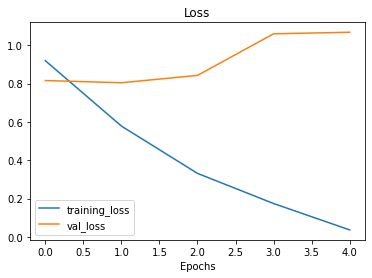

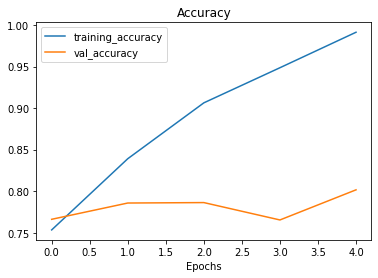

In [48]:
plot_loss_curves(history_101_food_classes_all_data_fine_tune)

In [44]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [45]:
loaded_model.save('efficientnetb0_fine_tuned_101_classes_mixed_precision')

INFO:tensorflow:Assets written to: efficientnetb0_fine_tuned_101_classes_mixed_precision/assets


INFO:tensorflow:Assets written to: efficientnetb0_fine_tuned_101_classes_mixed_precision/assets


In [ ]:
!tensorboard dev upload --logdir ./training_logs \
  --name "Fine-tuning EfficientNetB0 on all Food101 Data" \
  --description "Training results for fine-tuning EfficientNetB0 on Food101 Data with learning rate 0.0001" \
  --one_shot

In [47]:
!tensorboard dev list

2021-08-04 20:48:38.706822: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
https://tensorboard.dev/experiment/9rujHrn1R1yeJBecrkRDPA/
	Name                 Fine-tuning EfficientNetB0 on all Food101 Data
	Description          Training results for fine-tuning EfficientNetB0 on Food101 Data with learning rate 0.0001
	Id                   9rujHrn1R1yeJBecrkRDPA
	Created              2021-08-04 20:48:04 (41 seconds ago)
	Updated              2021-08-04 20:48:06 (39 seconds ago)
	Runs                 4
	Tags                 3
	Scalars              32
	Tensor bytes         0
	Binary object bytes  2079943
Total: 1 experiment(s)
